In [1]:
%load_ext pretty_jupyter
import pandas as pd
import numpy as np




# Test rerun on the server

The `get_sample_TSV.nf` script has been executed on the following samples:

- `data/read_only/samples/processed/processed.AS22WG001.trio.genotype.norm.filt.soi.vcf.gz`
- `data/read_only/samples/processed/processed.AS22WG004.merge.family.vep.vcf.gz`
- `data/read_only/samples/processed/processed.AS22WG009.trio.genotype.norm.filt.soi.vcf.gz`

The command used for thisn run:
```
nextflow run get_sample_TSV.nf --gnomADByRegionDir data/pipeline_outputs/variants_gnomAD --DBXCLI dbxcli --uploadDir Nitzan_Gonen_lab/Joint_projects/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD --VENV /home/dsi/toozig/.virtualenvs/deepBindEnv/bin/activate --MAX_REGIONS 10000 --REGION_SPLIT_SIZE 6000 --all_samples data/read_only/samples/processed/all_samples.txt --output_dir data/pipeline_outputs/variants_gnomAD --sample_file test_samples.txt --upload false --bed_file data/read_only/ATAC_seq/merged/merged_mATAC_hATAC_0507.bed  -params-file get_sample_TSV.json
```

This script performs several operations on the VCF files of each sample. It first adds the interval ID to each sample and removes variants that fall outside these intervals. The script then converts the modified VCF file into a TSV format and merges it with the gnomAD database. This is the process that generates the final output.

The final output can be found in- <br>
`/dsi/gonen-lab/shared_files/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD/merged_mATAC_hATAC_0507/test_samples/merged_mATAC_hATAC_0507.test_samples.parquet`<br>
 

> note: the output is a parquet format file and not a standart format. the file afterward being processed by Roni script for QC


> The file was not upload to the cloud, since this is just a test




In [2]:
samples_file = '/home/dsi/toozig/gonen-lab/users/toozig/projects/WGS_DSD-get_gnomAD/data/pipeline_outputs/variants_gnomAD/merged_mATAC_hATAC_0507/test_samples/merged_mATAC_hATAC_0507.test_samples.parquet'
df = pd.read_parquet(samples_file)
display(df.head())
print(f'there are total {len(df)} variants (rows) in the file\n describing {len(df.columns) // 4} samples')

,CHROM,POS,REF,ALT,FILTER,AF,AF_popmax,INTERVAL_ID,AS22WG001:GT,AS22WG001:DP,...,AS22WG009:GQ,AS22WG009:AB,AS22WG010:GT,AS22WG010:DP,AS22WG010:GQ,AS22WG010:AB,AS22WG011:GT,AS22WG011:DP,AS22WG011:GQ,AS22WG011:AB
0,chr1,629914,A,G,PASS,0.000042,0.000810,SE0,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000
1,chr1,629990,G,A,PASS,0.004910,0.038635,SE0,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000
2,chr1,633887,G,A,AS_VQSR,0.447185,0.671532,GR.PG.SE1,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000
3,chr1,634112,T,C,AS_VQSR;InbreedingCoeff,0.581946,0.687968,GR.PG.SE1,0/1,81,...,99,0.569767,0/1,46,99,0.73913,0/1,46,99,0.347826
4,chr1,634321,T,C,PASS,0.000008,0.000217,GR.PG.SE1,,-1,...,-1,0.000000,,-1,-1,0.00000,,-1,-1,0.000000


there are total 303424 variants (rows) in the file
 describing 13 samples


In [3]:
def get_per_sample(df):
    samples_vars = df[df.columns[df.columns.str.contains('GT')]].replace('0/0', '').replace('',np.nan).notna().sum(axis=0)
    return samples_vars
    
GT_df = df[df.columns[df.columns.str.contains('GT')]]
samples_vars = df[df.columns[df.columns.str.contains('GT')]].replace('0/0', '').replace('',np.nan).notna().sum(axis=0)

novel_df = df[df.AF_popmax == -1]
novel_per_sample = novel_df[novel_df.columns[novel_df.columns.str.contains('GT')]].replace('0/0', '').replace('',np.nan).notna().sum(axis=0)

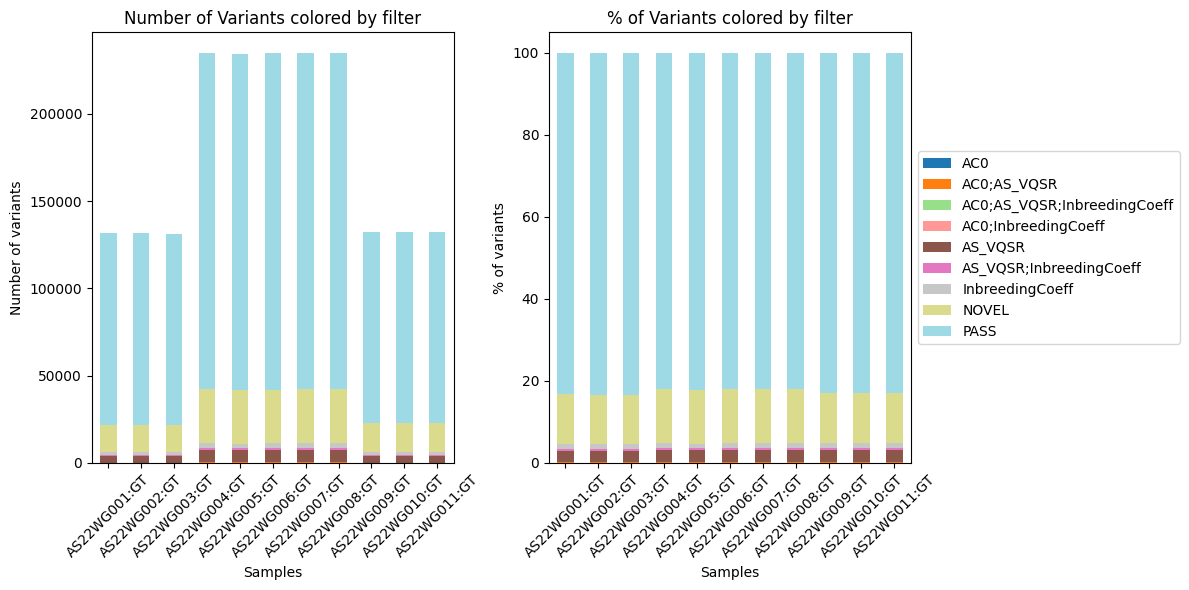

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def manipulate_data(df, GT_df):
    filter_df = df[['FILTER'] + GT_df.columns.tolist()] 
    filter_df.loc[:,"FILTER"] = filter_df.FILTER.replace(' ','NOVEL')
    metl_df = filter_df.melt(id_vars='FILTER')
    metl_df = metl_df.replace(' ',np.nan).dropna()

    sum_df = metl_df.drop(columns='value').groupby('variable').FILTER.value_counts().unstack()
    sum_df.loc[:,'total'] = sum_df.sum(axis=1)

    precent_df = sum_df.div(sum_df.total, axis=0) * 100

    return sum_df, precent_df


def plot_data(df, ax, title, ylabel, yticks=None, legend=True):
    df.drop(columns='total').plot(kind='bar', stacked=True, ax=ax,  colormap='tab20')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        ax.get_legend().remove()
    ax.set_title(title)
    ax.set_xlabel('Samples')
    ax.set_ylabel(ylabel)
    if yticks is not None:
        ax.set_yticks(yticks)

def plot_variant_distribution(sum_df, precent_df):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1,2, figsize=(12, 6))

    plot_data(sum_df, axs[0], 'Number of Variants colored by filter', 'Number of variants', legend=False)
    plot_data(precent_df, axs[1], '% of Variants colored by filter', '% of variants', np.arange(0, 110, 20))

    plt.tight_layout()
    plt.show()


sum_df, precent_df = manipulate_data(df, GT_df)
plot_variant_distribution(sum_df, precent_df)

In [5]:
def plot_data(df, ax, title, ylabel, yticks=None, legend=True):
    df.drop(columns='total').plot(kind='bar', stacked=True, ax=ax,  colormap='tab20')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        ax.get_legend().remove()
    ax.set_title(title)
    ax.set_xlabel('Samples')
    ax.set_ylabel(ylabel)
    if yticks is not None:
        ax.set_yticks(yticks)

def plot_variant_distribution(sum_df, precent_df):
    # Create a figure with two subplots
    fig, axs = plt.subplots(2, figsize=(6, 6))

    plot_data(sum_df, axs[0], 'Number of Variants colored by filter', 'Number of variants', legend=False)
    plot_data(precent_df, axs[1], '% of Variants colored by filter', '% of variants', np.arange(0, 110, 20))

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_1707326/3773055024.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gnomad_pss['AF_popmax'] = df.AF_popmax
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


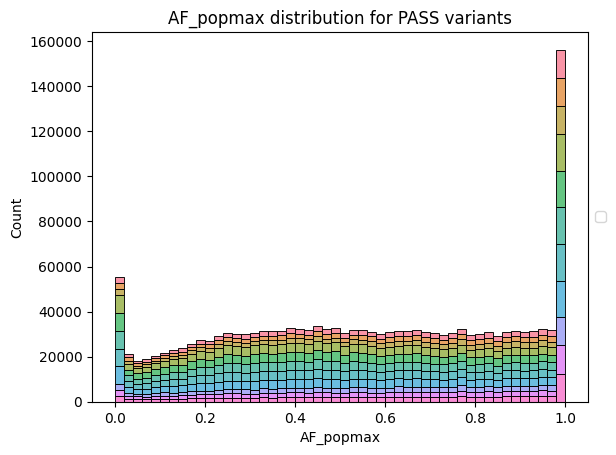

In [6]:

gnomAD_df = df[df.AF_popmax != -1][['FILTER'] + GT_df.columns.tolist()]
gnomad_pss = gnomAD_df[gnomAD_df.FILTER == 'PASS']
gnomad_pss['AF_popmax'] = df.AF_popmax
import seaborn as sns 
# plot violin plot of the AF_popmax distribution for PASS variants
melt_df = gnomad_pss.melt(id_vars=['AF_popmax','FILTER']).replace('0/0', '')
empty = melt_df.value.values[0]
melt_df = melt_df.replace(empty, np.nan)
melt_df = melt_df.dropna()
# plot histogram of AF_popmax, make it stacked and color by the 'variable' column
plot = sns.histplot(melt_df, x='AF_popmax', hue='variable', multiple='stack', bins=50)
plot.set_title('AF_popmax distribution for PASS variants')
# move the legend to the side and show it
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


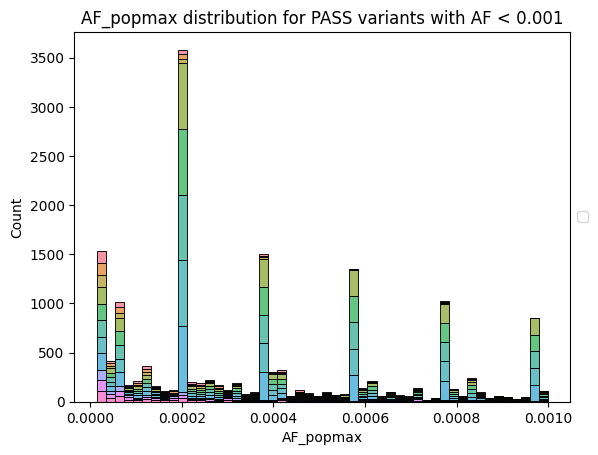

In [7]:
low_AF = melt_df[melt_df.AF_popmax < 0.001]
plot = sns.histplot(low_AF, x='AF_popmax', hue='variable', multiple='stack', bins=50)
plot.set_title('AF_popmax distribution for PASS variants with AF < 0.001')
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [8]:
old_path = 'merged_mATAC_hATAC_0507.all_samples.parquet'
df2 = pd.read_parquet(old_path)
df2 = df2[['FILTER', 'AF_popmax'] + GT_df.columns.tolist()]
metl_df2 = df2.melt(id_vars=['FILTER','AF_popmax'])
metl_df2 = metl_df2.replace(' ',np.nan).replace('0/0',np.nan).replace('0|0',np.nan).dropna()

FileNotFoundError: [Errno 2] No such file or directory: 'merged_mATAC_hATAC_0507.all_samples.parquet'

In [ ]:
metl_df2.value.value_counts()

value
0/1    742213
1/1    559426
0|1    106258
1|1     73596
1/0     18709
1|0        84
Name: count, dtype: int64

In [ ]:
metl_df2.groupby('variable').FILTER.describe()

,count,unique,top,freq
variable,,,,
AS22WG001:GT,128657,6,PASS,121879
AS22WG002:GT,101856,6,PASS,97129
AS22WG003:GT,101915,6,PASS,97049
AS22WG004:GT,167086,8,PASS,160163
AS22WG005:GT,165497,8,PASS,159356
AS22WG006:GT,165669,8,PASS,159429
AS22WG007:GT,167296,8,PASS,160576
AS22WG008:GT,167688,8,PASS,160853
AS22WG009:GT,129604,6,PASS,122629


In [9]:
df3 = df[['FILTER', 'AF_popmax'] + GT_df.columns.tolist()]
metl_df3 = df3.melt(id_vars=['FILTER','AF_popmax'])
metl_df3 = metl_df3.replace(' ',np.nan).dropna()

In [10]:
metl_df3.value.value_counts()

value
0/1    763405
1/1    567320
0/0    366839
1/0     16969
Name: count, dtype: int64

In [11]:
metl_df3.groupby('variable').FILTER.describe()

,count,unique,top,freq
variable,,,,
AS22WG001:GT,115793,6,PASS,109608
AS22WG002:GT,115728,6,PASS,109571
AS22WG003:GT,115672,6,PASS,109542
AS22WG004:GT,203946,8,PASS,192705
AS22WG005:GT,203543,8,PASS,192475
AS22WG006:GT,203781,8,PASS,192599
AS22WG007:GT,204034,8,PASS,192777
AS22WG008:GT,203926,8,PASS,192723
AS22WG009:GT,116090,6,PASS,109714


In [13]:
latesst_used_path = '/dsi/gonen-lab/shared_files/WGS_on_DSD/data/pipeline_outputs/variants_gnomAD/05_05_24_00/merged_mATAC_hATAC_0507.all_samples.parquet'
df4 = pd.read_parquet(latesst_used_path)
df4.head()
df4_f = df4[df4.columns[df4.columns.isin(df.columns)]]

In [37]:
# drop all DP cols, GQ, AB
df4_f = df4_f.drop(columns=df4_f.columns[df4_f.columns.str.contains('DP|GQ|AB')])
df4_f = df4_f.melt(id_vars=['CHROM','POS','REF','ALT','FILTER','AF_popmax','AF','INTERVAL_ID'])


In [39]:
# drop all empty / None in value 
df4_f = df4_f.replace(' ','').replace('0/0', '').replace('',np.nan).dropna()

,CHROM,POS,REF,ALT,FILTER,AF_popmax,AF,INTERVAL_ID,variable,value
7,chr1,29443,A,G,AS_VQSR,0.000408,0.000371,51153_XY1235,AS22WG001:GT,1/1
42,chr1,778406,G,GGCT,AS_VQSR;InbreedingCoeff,0.282171,0.164694,GR.PG.PS.SE2,AS22WG001:GT,0/1
62,chr1,779047,G,A,PASS,0.950341,0.819806,GR.PG.PS.SE2,AS22WG001:GT,1/1
72,chr1,826893,G,A,PASS,0.894094,0.730133,GR.PG.PS.SE3,AS22WG001:GT,1/1
81,chr1,827209,G,C,PASS,0.892332,0.739536,GR.PG.PS.SE3,AS22WG001:GT,1/1
...,...,...,...,...,...,...,...,...,...,...
12932457,chrX,155767914,GTTTTGTT,G,PASS,0.124224,0.088310,GR.PG.PS42006,AS22WG011:GT,0/1
12932463,chrX,155768244,C,CG,InbreedingCoeff,0.756978,0.705039,GR.PG.PS42006,AS22WG011:GT,1/1
12932471,chrX,155768650,G,T,PASS,0.800273,0.527241,GR.PG.PS42006,AS22WG011:GT,0/1
12932473,chrX,155768714,G,C,PASS,0.676562,0.420669,GR.PG.PS42006,AS22WG011:GT,0/1


In [40]:
df4_f.value.value_counts()

value
0/1    1100246
1/1     721936
1/0      23910
Name: count, dtype: int64

In [41]:
# do the same for df
df_f = df.drop(columns=df.columns[df.columns.str.contains('DP|GQ|AB')])
df_f = df_f.melt(id_vars=['CHROM','POS','REF','ALT','FILTER','AF_popmax','AF','INTERVAL_ID'])
df_f = df_f.replace(' ','').replace('0/0', '').replace('',np.nan).dropna()
df_f.value.value_counts()

value
0/1    763405
1/1    567320
1/0     16969
Name: count, dtype: int64

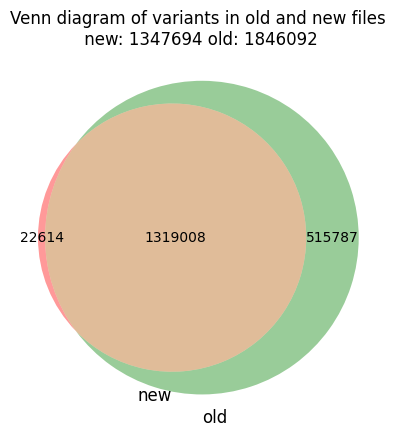

In [50]:
# create Id using the loci of the variant + the sample name
df_f['ID'] = df_f.CHROM + ':' + df_f.POS.astype(str) + ':' + df_f.variable
df4_f['ID'] = df4_f.CHROM + ':' + df4_f.POS.astype(str) + ':' + df4_f.variable
# how many are in both - in venn digram
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
venn2([set(df_f.ID), set(df4_f.ID)], set_labels=('new', 'old'))
# add the number of variants in each set
plt.title(f'Venn diagram of variants in old and new files\n new: {len(df_f)} old: {len(df4_f)}')
plt.show()



In [46]:
# create a df of al the variant in the new df that are not in the old
new_variants = df_f[~df_f.ID.isin(df4_f.ID)]
new_variants

,CHROM,POS,REF,ALT,FILTER,AF_popmax,AF,INTERVAL_ID,variable,value,ID
3,chr1,634112,T,C,AS_VQSR;InbreedingCoeff,0.687968,0.581946,GR.PG.SE1,AS22WG001:GT,0/1,chr1:634112:AS22WG001:GT
145,chr1,1000814,A,G,PASS,0.879424,0.692247,GR.PG.PS.SE16,AS22WG001:GT,0/1,chr1:1000814:AS22WG001:GT
166,chr1,1020060,GC,G,PASS,0.743760,0.485983,83504_XY1235_GR.PG.PS.SE20,AS22WG001:GT,0/1,chr1:1020060:AS22WG001:GT
187,chr1,1033770,T,G,AC0;AS_VQSR,-1.000000,0.000000,83502_XY135X2_GR.PG.PS.SE22,AS22WG001:GT,0/1,chr1:1033770:AS22WG001:GT
212,chr1,1079370,G,C,PASS,0.003067,0.002086,GR.PG.PS.SE27,AS22WG001:GT,1/1,chr1:1079370:AS22WG001:GT
...,...,...,...,...,...,...,...,...,...,...,...
3337089,chrX,135974140,G,A,PASS,0.814815,0.726644,119124_XY1235_GR.PG.PS.SE41861,AS22WG011:GT,1/1,chrX:135974140:AS22WG011:GT
3337225,chrX,143720411,C,A,PASS,0.733049,0.528716,PG41887,AS22WG011:GT,0/1,chrX:143720411:AS22WG011:GT
3337230,chrX,143720482,C,T,PASS,0.312854,0.099357,PG41887,AS22WG011:GT,0/1,chrX:143720482:AS22WG011:GT
3337352,chrX,150983468,T,G,PASS,-1.000000,0.000010,119300_XY1235_GR.PG.PS.SE41914,AS22WG011:GT,0/1,chrX:150983468:AS22WG011:GT


In [48]:
old_variants = df4_f[~df4_f.ID.isin(df_f.ID)]
old_variants

,CHROM,POS,REF,ALT,FILTER,AF_popmax,AF,INTERVAL_ID,variable,value,ID
7,chr1,29443,A,G,AS_VQSR,0.000408,0.000371,51153_XY1235,AS22WG001:GT,1/1,chr1:29443:AS22WG001:GT
119,chr1,904158,G,A,PASS,0.011808,0.007893,GR.PG.PS.SE5,AS22WG001:GT,0/1,chr1:904158:AS22WG001:GT
146,chr1,904539,T,G,PASS,0.054650,0.013765,GR.PG.PS.SE5,AS22WG001:GT,1/1,chr1:904539:AS22WG001:GT
152,chr1,904554,GGCC,G,PASS,0.009542,0.002858,GR.PG.PS.SE5,AS22WG001:GT,1/1,chr1:904554:AS22WG001:GT
156,chr1,904564,TCCTCCGAACGTGG,T,PASS,0.030454,0.005002,GR.PG.PS.SE5,AS22WG001:GT,1/1,chr1:904564:AS22WG001:GT
...,...,...,...,...,...,...,...,...,...,...,...
12932328,chrX,154751295,T,G,PASS,0.825888,0.403071,119440_XY1235_PG.SE41996,AS22WG011:GT,0/1,chrX:154751295:AS22WG011:GT
12932389,chrX,155147767,T,C,InbreedingCoeff,1.000000,0.991843,119454_XY13Y25,AS22WG011:GT,1/1,chrX:155147767:AS22WG011:GT
12932391,chrX,155263821,G,A,PASS,0.757502,0.615801,119456_XY135X2_GR.PG.SE42004,AS22WG011:GT,0/1,chrX:155263821:AS22WG011:GT
12932402,chrX,155613005,C,T,PASS,0.770746,0.631061,GR.PG.SE42005,AS22WG011:GT,0/1,chrX:155613005:AS22WG011:GT


In [30]:
none_df = df4_f[[col for col in df4_f.columns if 'GT' in col]].replace(' ',None).replace('0/0',None).replace('0|0',None)
old_count = none_df.melt().groupby('variable').value.value_counts()

In [31]:
new_df = df[[col for col in df.columns if 'GT' in col]].replace(' ',None).replace('0/0',None).replace('0|0',None)
new_count = new_df.melt().groupby('variable').value.value_counts()

value,0/1,1/0,1/1
variable,,,
AS22WG001:GT,104370,3093,63696
AS22WG002:GT,105943,3044,63525
AS22WG003:GT,106175,2909,63533
AS22WG004:GT,100804,3168,69847
AS22WG005:GT,100746,3103,70465
AS22WG006:GT,100358,2985,71138
AS22WG007:GT,101616,3275,69326
AS22WG008:GT,103386,3187,68424
AS22WG009:GT,104917,3058,64017


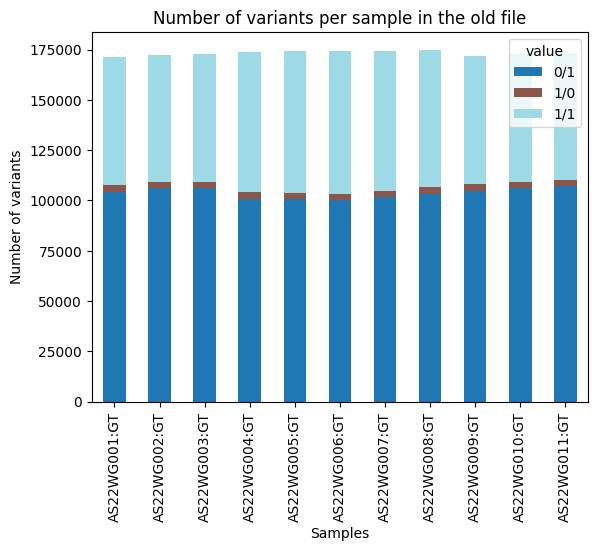

In [33]:
#creat plot of the number of variants per sample
old_count.unstack().plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Number of variants per sample in the old file')
plt.xlabel('Samples')
plt.ylabel('Number of variants')
display(old_count.unstack())

value,0/1,1/0,1/1
variable,,,
AS22WG001:GT,80732,2273,48574
AS22WG002:GT,53411,1960,48275
AS22WG003:GT,53575,1876,48154
AS22WG004:GT,99024,2790,69994
AS22WG005:GT,97067,2355,70394
AS22WG006:GT,96406,2375,71265
AS22WG007:GT,99777,2731,69398
AS22WG008:GT,101061,2726,68533
AS22WG009:GT,81432,2231,48721


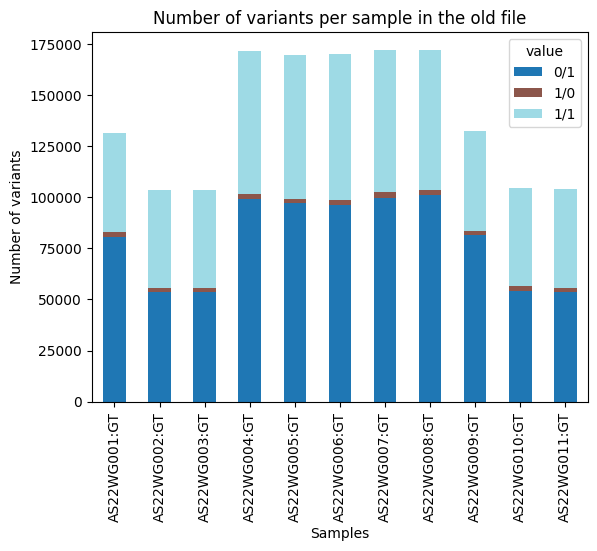

In [34]:
#creat plot of the number of variants per sample
new_count.unstack().plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Number of variants per sample in the new file')
plt.xlabel('Samples')
plt.ylabel('Number of variants')
display(new_count.unstack())